# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkirchen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.


In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import time
import os
import cv2
import sys

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

Tensorflow Version: 1.13.1
Keras Version: 2.2.4-tf


Progressbar function

In [2]:
def update_progress(progress, custom=""):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = custom + "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, end="\r")

### Sequential model
In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

In [3]:
# Layer 1
Conv2DLayer1 = layers.Conv2D(input_shape = (101,101,1),
                             filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005)) 

ActivationLayer1 = layers.Activation("tanh")

NormalizationLayer1 = layers.BatchNormalization()

PoolingLayer1 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")

# Layer 2
Conv2DLayer2 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer2 = layers.Activation("tanh")

NormalizationLayer2 = layers.BatchNormalization()

PoolingLayer2 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 3
Conv2DLayer3 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer3 = layers.Activation("tanh")

NormalizationLayer3 = layers.BatchNormalization()

PoolingLayer3 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 4
Conv2DLayer4 = layers.Conv2D(filters = 32,
                             kernel_size = (3,3),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer4 = layers.Activation("tanh")

NormalizationLayer4 = layers.BatchNormalization()

PoolingLayer4 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Fully Connected Layer
FlattenLayer5 = layers.Flatten()
#DenseLayer5 = layers.Dense(200, kernel_initializer = "glorot_uniform")
DenseLayer5 = layers.Dense(130, kernel_initializer = "glorot_uniform")
ActivationLayer5 = layers.Activation("tanh")
NormalizationLayer5 = layers.BatchNormalization()

# Softmax Classifier
DenseLayer6 = layers.Dense(3)
ActivationLayer6 = layers.Activation("softmax")

model_architecture = [
         Conv2DLayer1,
         ActivationLayer1,
         NormalizationLayer1,
         PoolingLayer1,
         
         Conv2DLayer2,
         ActivationLayer2,
         NormalizationLayer2,
         PoolingLayer2,
         
#         Conv2DLayer3,
#         ActivationLayer3,
#         NormalizationLayer3,
#         PoolingLayer3,
         
#         Conv2DLayer4,
#         ActivationLayer4,
#         NormalizationLayer4,
#         PoolingLayer4,
         
         FlattenLayer5,
         DenseLayer5,
         ActivationLayer5,
         NormalizationLayer5,
         
         DenseLayer6,
         ActivationLayer6]

model = tf.keras.Sequential(model_architecture)

### Prints a summary representation of the model

In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        544       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        16416     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 46, 46, 32)        128       
__________

### Plot a graph of the model and save it to a file

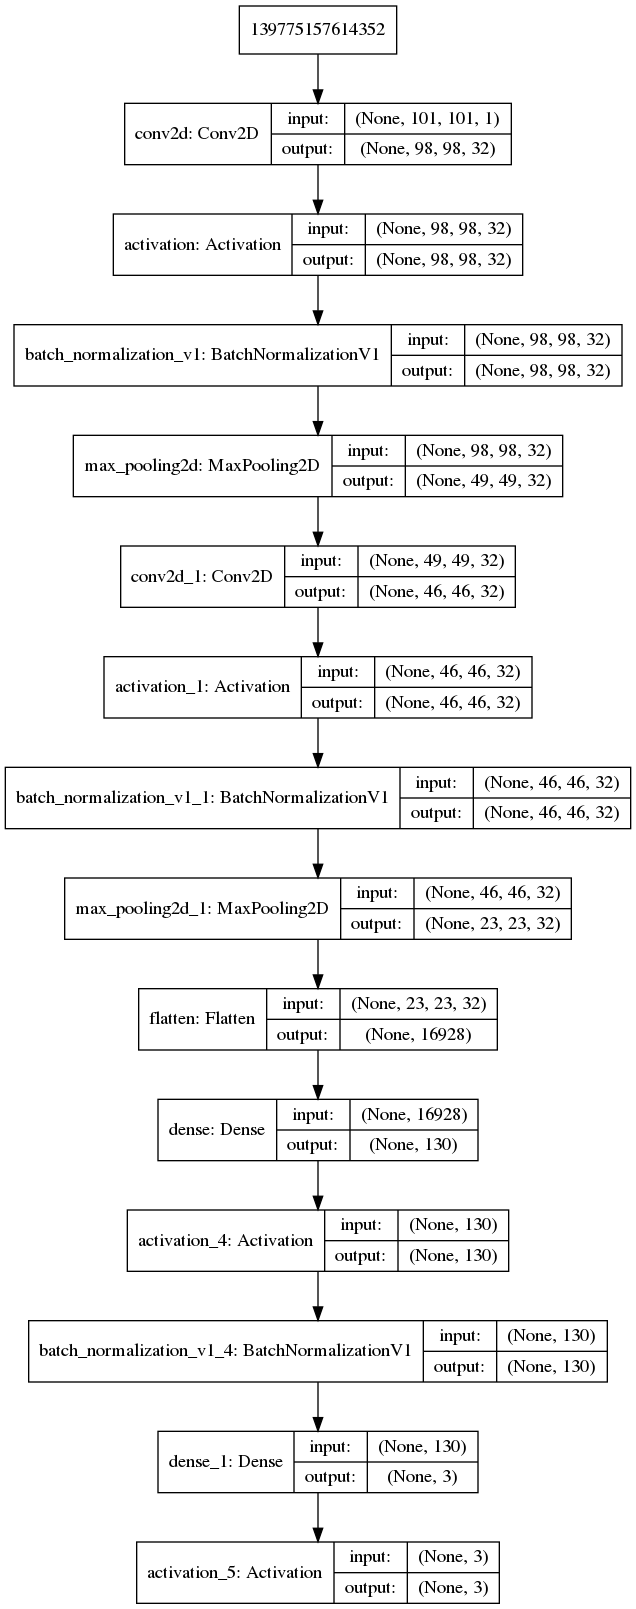

In [5]:
utils.plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'plots/model.png')
Image(retina = True, filename = 'plots/model.png')

## Set up Training

Arguments for Training, that we need to set are:
* The path to the input dataset.
* The number of epochs to train for.
* Path for Our loss/accuracy plot, that will be output to disk
* etc.

In [6]:
MODEL_NAME = "corridor"
DATASET_PATH = os.getcwd() + "/dataset/corridor"
VALIDATION_PATH = DATASET_PATH + "/validation"
TRAIN_PATH = DATASET_PATH + "/train"
TRAIN_EVAL_PLOT_PATH = os.getcwd() + "/plots"

DATASET_PATH_MODIFIED =  os.getcwd() + "/dataset/corridor_m"
VALIDATION_PATH_MODIFIED = DATASET_PATH_MODIFIED + "/validation"
TRAIN_PATH_MODIFIED = DATASET_PATH_MODIFIED + "/train"

NUMBER_OF_EPOCHS = 300
BATCH_SIZE = 64
INIT_LEARNING_RATE = 1e-4
DECAY_LEARNING_RATE = 1e-4 / NUMBER_OF_EPOCHS

Here we can see the dataset structure:

+ dataset / corridor
    
    - validation
        - left (X Files)
        - forward (X Files)
        - right (X Files)
    - train
        - left (X Files)
        - forward (X Files)
        - right (X Files)

Initialize the set of labels from dataset we are going to train our network on.

In [7]:
LABELS = list(["left","forward","right"])

Genrate a list of image pathes for our training

In [8]:
train_image_paths = list(paths.list_images(TRAIN_PATH))
validation_image_paths = list(paths.list_images(VALIDATION_PATH))

print("Size of the train-dataset: " + str(len(train_image_paths)))
print("Size of the validation-dataset: " + str(len(validation_image_paths)))

Size of the train-dataset: 30914
Size of the validation-dataset: 15305


Load default dataset and create a new one with data augemtation. Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images.

In [9]:
i = 0.0
for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)[212:906, 468:1399]
    image = cv2.resize(image, (101, 101))
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + label + '/' + filename, image)

In [10]:
train_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED))

In [11]:
i = 0.0
for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    if label == 'left':
        label = 'right'
    elif label == 'right':
        label = 'left'
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.flip(cv2.imread(imagePath), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + label + '/f' + filename, image)

Create some images that simulate a wall over the half picture.

In [12]:
forward_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED + '/' + 'forward'))

In [13]:
i = 0.0
for forward_image_path in forward_image_paths:

    update_progress(i / len(forward_image_paths), "Generating left images ")
    i = i + 1.0
    
    filename = forward_image_path.split(os.path.sep)[-1]
 
    image = cv2.imread(forward_image_path,cv2.IMREAD_GRAYSCALE)
    width = image.shape[1]
    image[:,0:width//2] = int(cv2.mean(image)[0])
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + 'l_1' + '/h' + filename, image)

In [14]:
i = 0.0
for forward_image_path in forward_image_paths:

    update_progress(i / len(forward_image_paths), "Generating right images ")
    i = i + 1.0
    
    filename = forward_image_path.split(os.path.sep)[-1]
 
    image = cv2.imread(forward_image_path,cv2.IMREAD_GRAYSCALE)

    image[:,width//2:width] = (cv2.mean(image)[0])
    cv2.imwrite(TRAIN_PATH_MODIFIED + '/' + 'right' + '/h' + filename, image)

In [15]:
train_image_paths = list(paths.list_images(TRAIN_PATH_MODIFIED))
print("Size of the train-dataset: " + str(len(train_image_paths)))

Size of the train-dataset: 80826


In [16]:
train_images = []
validation_images = []

train_labels = []
validation_labels = []
i = 0.0

for imagePath in train_image_paths:

    update_progress(i / len(train_image_paths), "Loading train images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
 
    train_images.append(image)
    train_labels.append(label)

In [17]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)[212:906, 468:1399]
    image = cv2.resize(image, (101, 101))
    cv2.imwrite(VALIDATION_PATH_MODIFIED + '/' + label + '/' + filename, image)

In [18]:
validation_image_paths = list(paths.list_images(VALIDATION_PATH_MODIFIED))

In [19]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
    if label == 'left':
        label = 'right'
    elif label == 'right':
        label = 'left'
    filename = imagePath.split(os.path.sep)[-1]
    if label not in LABELS:
        continue

    image = cv2.flip(cv2.imread(imagePath), cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(VALIDATION_PATH_MODIFIED + '/' + label + '/f' + filename, image)

In [20]:
validation_image_paths = list(paths.list_images(VALIDATION_PATH_MODIFIED))
print("Size of the validation-dataset: " + str(len(validation_image_paths)))

Size of the validation-dataset: 30610


In [21]:
i = 0.0
for imagePath in validation_image_paths:

    update_progress(i / len(validation_image_paths), "Loading validation images ")
    i = i + 1.0
    
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
 
    validation_images.append(image)
    validation_labels.append(label)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
print("Size of the train-dataset: " + str(len(train_images)))
print("Size of the validation-dataset: " + str(len(validation_images)))

Size of the train-dataset: 80826
Size of the validation-dataset: 30610


Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [23]:
train_images = np.expand_dims(np.array(train_images, dtype = "float") / 255.0, axis=3)
validation_images = np.expand_dims(np.array(validation_images, dtype = "float") / 255.0, axis=3)
print(train_images.shape)

(80826, 101, 101, 1)


Creating one-hot encoding vectors on the labels (for each image!)

In [24]:
left_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
forward_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))
right_hot_encoding = np.ndarray((3,),dtype=np.int64,strides=(8,))

train_hot_encoding_vectors = []
validation_hot_encoding_vectors = []

left_hot_encoding[:] =    [1, 0, 0]
forward_hot_encoding[:] = [0, 1, 0]
right_hot_encoding[:] =   [0, 0, 1]

for label in train_labels:
    if(label == "left"):
        train_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        train_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        train_hot_encoding_vectors.append(right_hot_encoding)
        
for label in validation_labels:
    if(label == "left"):
        validation_hot_encoding_vectors.append(left_hot_encoding)
    elif(label == "forward"):
        validation_hot_encoding_vectors.append(forward_hot_encoding)
    elif(label == "right"):
        validation_hot_encoding_vectors.append(right_hot_encoding)

train_hot_encoding_vectors = np.asarray(train_hot_encoding_vectors)
validation_hot_encoding_vectors = np.asarray(validation_hot_encoding_vectors)

In [25]:
for i in range(len(LABELS)):
    index = train_labels.index(LABELS[i])
    print(str(LABELS[i]) + ":" + str(train_hot_encoding_vectors[index]))

#for i in range(len(LABELS)):
#    index = validation_labels.index(LABELS[i])
#    print(str(LABELS[i]) + ":" + str(validation_hot_encoding_vectors[index]))

left:[1 0 0]
forward:[0 1 0]
right:[0 0 1]


Construct the training image generator for data augmentation

In [26]:
dataAugmentation = preprocessing.image.ImageDataGenerator(rotation_range = 15,
                                                          zoom_range = 0.10,
                                                          width_shift_range = 0.1,
                                                          height_shift_range = 0.1,
                                                          shear_range = 0.0,
                                                          horizontal_flip = False,
                                                          vertical_flip = False,
                                                          fill_mode="nearest")

Initialize Adam Optimizer

In [29]:
#sgdOptimizer = optimizers.SGD(lr=INIT_LEARNING_RATE, momentum=0.75, decay=DECAY_LEARNING_RATE, nesterov=True)
adamOptimizer = optimizers.Adam(lr = INIT_LEARNING_RATE, decay = DECAY_LEARNING_RATE)

After the model is constructed, configure its learning process by calling the compile method

In [30]:
model.compile(loss = "categorical_crossentropy", optimizer = adamOptimizer, metrics = ["accuracy"])

Save the entire model (HDF5 file) after every epoch (period).

In [31]:
checkpoint_saver = tf.keras.callbacks.ModelCheckpoint('./checkpoints/'+ MODEL_NAME +'_weights{epoch:08d}.h5',
                                save_weights_only=False,
                                period=1,
                                verbose=1,
                                save_best_only=False,
                                mode='auto')

## Training

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [32]:
tf.test.is_gpu_available(cuda_only = True)

True

Training the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

In [33]:
start_time = time.time()

trainHistory = model.fit_generator(dataAugmentation.flow(train_images, train_hot_encoding_vectors, batch_size = BATCH_SIZE),
                                   validation_data = (validation_images, validation_hot_encoding_vectors),
                                   steps_per_epoch = len(train_images) // BATCH_SIZE,
                                   epochs = NUMBER_OF_EPOCHS,
                                   verbose = 2,
                                   callbacks = [checkpoint_saver])

end_time = time.time()

Epoch 1/300
30610/30610 [==============================] - 7s 240us/sample - loss: 0.5274 - acc: 0.7943

Epoch 00001: saving model to ./checkpoints/corridor_weights00000001.h5
 - 87s - loss: 0.4925 - acc: 0.8076 - val_loss: 0.5273 - val_acc: 0.7943
Epoch 2/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.4049 - acc: 0.8482

Epoch 00002: saving model to ./checkpoints/corridor_weights00000002.h5
 - 83s - loss: 0.2785 - acc: 0.9003 - val_loss: 0.4054 - val_acc: 0.8482
Epoch 3/300
30610/30610 [==============================] - 7s 230us/sample - loss: 0.2784 - acc: 0.9020

Epoch 00003: saving model to ./checkpoints/corridor_weights00000003.h5
 - 84s - loss: 0.2147 - acc: 0.9251 - val_loss: 0.2785 - val_acc: 0.9020
Epoch 4/300
30610/30610 [==============================] - 7s 233us/sample - loss: 0.5687 - acc: 0.7937

Epoch 00004: saving model to ./checkpoints/corridor_weights00000004.h5
 - 85s - loss: 0.1816 - acc: 0.9391 - val_loss: 0.5689 - val_acc: 0.7937
Epoc

Epoch 34/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.3958 - acc: 0.8720

Epoch 00034: saving model to ./checkpoints/corridor_weights00000034.h5
 - 84s - loss: 0.0663 - acc: 0.9795 - val_loss: 0.3967 - val_acc: 0.8720
Epoch 35/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.3915 - acc: 0.8778

Epoch 00035: saving model to ./checkpoints/corridor_weights00000035.h5
 - 85s - loss: 0.0635 - acc: 0.9799 - val_loss: 0.3925 - val_acc: 0.8778
Epoch 36/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.2743 - acc: 0.9120

Epoch 00036: saving model to ./checkpoints/corridor_weights00000036.h5
 - 85s - loss: 0.0616 - acc: 0.9807 - val_loss: 0.2750 - val_acc: 0.9120
Epoch 37/300
30610/30610 [==============================] - 7s 229us/sample - loss: 0.3113 - acc: 0.8916

Epoch 00037: saving model to ./checkpoints/corridor_weights00000037.h5
 - 85s - loss: 0.0624 - acc: 0.9803 - val_loss: 0.3122 - val_acc: 0.8916


Epoch 67/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.4759 - acc: 0.8602

Epoch 00067: saving model to ./checkpoints/corridor_weights00000067.h5
 - 85s - loss: 0.0476 - acc: 0.9844 - val_loss: 0.4770 - val_acc: 0.8602
Epoch 68/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.3040 - acc: 0.9127

Epoch 00068: saving model to ./checkpoints/corridor_weights00000068.h5
 - 84s - loss: 0.0492 - acc: 0.9841 - val_loss: 0.3052 - val_acc: 0.9127
Epoch 69/300
30610/30610 [==============================] - 7s 231us/sample - loss: 1.5108 - acc: 0.6234

Epoch 00069: saving model to ./checkpoints/corridor_weights00000069.h5
 - 86s - loss: 0.0459 - acc: 0.9854 - val_loss: 1.5093 - val_acc: 0.6234
Epoch 70/300
30610/30610 [==============================] - 7s 230us/sample - loss: 0.4604 - acc: 0.8651

Epoch 00070: saving model to ./checkpoints/corridor_weights00000070.h5
 - 85s - loss: 0.0468 - acc: 0.9852 - val_loss: 0.4605 - val_acc: 0.8651


Epoch 100/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.4141 - acc: 0.8882

Epoch 00100: saving model to ./checkpoints/corridor_weights00000100.h5
 - 85s - loss: 0.0411 - acc: 0.9866 - val_loss: 0.4147 - val_acc: 0.8882
Epoch 101/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.3538 - acc: 0.8916

Epoch 00101: saving model to ./checkpoints/corridor_weights00000101.h5
 - 84s - loss: 0.0413 - acc: 0.9865 - val_loss: 0.3536 - val_acc: 0.8916
Epoch 102/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.3581 - acc: 0.8975

Epoch 00102: saving model to ./checkpoints/corridor_weights00000102.h5
 - 84s - loss: 0.0406 - acc: 0.9869 - val_loss: 0.3581 - val_acc: 0.8975
Epoch 103/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.4630 - acc: 0.8754

Epoch 00103: saving model to ./checkpoints/corridor_weights00000103.h5
 - 84s - loss: 0.0439 - acc: 0.9865 - val_loss: 0.4639 - val_acc: 0.8

 - 85s - loss: 0.0368 - acc: 0.9878 - val_loss: 0.6350 - val_acc: 0.8334
Epoch 133/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.4872 - acc: 0.8667

Epoch 00133: saving model to ./checkpoints/corridor_weights00000133.h5
 - 84s - loss: 0.0395 - acc: 0.9870 - val_loss: 0.4875 - val_acc: 0.8667
Epoch 134/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.5075 - acc: 0.8553

Epoch 00134: saving model to ./checkpoints/corridor_weights00000134.h5
 - 85s - loss: 0.0372 - acc: 0.9881 - val_loss: 0.5087 - val_acc: 0.8553
Epoch 135/300
30610/30610 [==============================] - 7s 227us/sample - loss: 1.0821 - acc: 0.7590

Epoch 00135: saving model to ./checkpoints/corridor_weights00000135.h5
 - 84s - loss: 0.0371 - acc: 0.9880 - val_loss: 1.0813 - val_acc: 0.7590
Epoch 136/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.4620 - acc: 0.8736

Epoch 00136: saving model to ./checkpoints/corridor_weights00000136

30610/30610 [==============================] - 7s 227us/sample - loss: 0.4367 - acc: 0.8747

Epoch 00165: saving model to ./checkpoints/corridor_weights00000165.h5
 - 85s - loss: 0.0361 - acc: 0.9885 - val_loss: 0.4374 - val_acc: 0.8747
Epoch 166/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.3951 - acc: 0.8881

Epoch 00166: saving model to ./checkpoints/corridor_weights00000166.h5
 - 85s - loss: 0.0366 - acc: 0.9881 - val_loss: 0.3965 - val_acc: 0.8881
Epoch 167/300
30610/30610 [==============================] - 7s 228us/sample - loss: 0.3280 - acc: 0.9002

Epoch 00167: saving model to ./checkpoints/corridor_weights00000167.h5
 - 85s - loss: 0.0360 - acc: 0.9881 - val_loss: 0.3294 - val_acc: 0.9002
Epoch 168/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.2991 - acc: 0.9060

Epoch 00168: saving model to ./checkpoints/corridor_weights00000168.h5
 - 85s - loss: 0.0355 - acc: 0.9882 - val_loss: 0.2994 - val_acc: 0.9060
Epoch 169/

 - 84s - loss: 0.0333 - acc: 0.9892 - val_loss: 0.3965 - val_acc: 0.8886
Epoch 198/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.7316 - acc: 0.7996

Epoch 00198: saving model to ./checkpoints/corridor_weights00000198.h5
 - 84s - loss: 0.0335 - acc: 0.9891 - val_loss: 0.7317 - val_acc: 0.7996
Epoch 199/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.3452 - acc: 0.8990

Epoch 00199: saving model to ./checkpoints/corridor_weights00000199.h5
 - 84s - loss: 0.0327 - acc: 0.9896 - val_loss: 0.3456 - val_acc: 0.8990
Epoch 200/300
30610/30610 [==============================] - 7s 229us/sample - loss: 0.4902 - acc: 0.8612

Epoch 00200: saving model to ./checkpoints/corridor_weights00000200.h5
 - 85s - loss: 0.0333 - acc: 0.9889 - val_loss: 0.4903 - val_acc: 0.8612
Epoch 201/300
30610/30610 [==============================] - 7s 229us/sample - loss: 0.5007 - acc: 0.8466

Epoch 00201: saving model to ./checkpoints/corridor_weights00000201

30610/30610 [==============================] - 7s 227us/sample - loss: 0.4351 - acc: 0.8779

Epoch 00230: saving model to ./checkpoints/corridor_weights00000230.h5
 - 85s - loss: 0.0328 - acc: 0.9893 - val_loss: 0.4359 - val_acc: 0.8779
Epoch 231/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.3720 - acc: 0.8925

Epoch 00231: saving model to ./checkpoints/corridor_weights00000231.h5
 - 85s - loss: 0.0323 - acc: 0.9895 - val_loss: 0.3723 - val_acc: 0.8925
Epoch 232/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.3944 - acc: 0.8978

Epoch 00232: saving model to ./checkpoints/corridor_weights00000232.h5
 - 84s - loss: 0.0327 - acc: 0.9892 - val_loss: 0.3948 - val_acc: 0.8978
Epoch 233/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.8810 - acc: 0.8068

Epoch 00233: saving model to ./checkpoints/corridor_weights00000233.h5
 - 85s - loss: 0.0319 - acc: 0.9895 - val_loss: 0.8819 - val_acc: 0.8068
Epoch 234/

 - 84s - loss: 0.0308 - acc: 0.9903 - val_loss: 1.4446 - val_acc: 0.7350
Epoch 263/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.4190 - acc: 0.8818

Epoch 00263: saving model to ./checkpoints/corridor_weights00000263.h5
 - 84s - loss: 0.0318 - acc: 0.9893 - val_loss: 0.4195 - val_acc: 0.8818
Epoch 264/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.4046 - acc: 0.8844

Epoch 00264: saving model to ./checkpoints/corridor_weights00000264.h5
 - 84s - loss: 0.0305 - acc: 0.9899 - val_loss: 0.4055 - val_acc: 0.8844
Epoch 265/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.4598 - acc: 0.8642

Epoch 00265: saving model to ./checkpoints/corridor_weights00000265.h5
 - 85s - loss: 0.0327 - acc: 0.9893 - val_loss: 0.4607 - val_acc: 0.8642
Epoch 266/300
30610/30610 [==============================] - 7s 226us/sample - loss: 0.5323 - acc: 0.8547

Epoch 00266: saving model to ./checkpoints/corridor_weights00000266

30610/30610 [==============================] - 7s 228us/sample - loss: 0.3849 - acc: 0.8875

Epoch 00295: saving model to ./checkpoints/corridor_weights00000295.h5
 - 84s - loss: 0.0300 - acc: 0.9902 - val_loss: 0.3867 - val_acc: 0.8875
Epoch 296/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.3632 - acc: 0.8978

Epoch 00296: saving model to ./checkpoints/corridor_weights00000296.h5
 - 84s - loss: 0.0305 - acc: 0.9900 - val_loss: 0.3636 - val_acc: 0.8978
Epoch 297/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.4025 - acc: 0.8936

Epoch 00297: saving model to ./checkpoints/corridor_weights00000297.h5
 - 85s - loss: 0.0290 - acc: 0.9901 - val_loss: 0.4035 - val_acc: 0.8936
Epoch 298/300
30610/30610 [==============================] - 7s 227us/sample - loss: 0.5017 - acc: 0.8701

Epoch 00298: saving model to ./checkpoints/corridor_weights00000298.h5
 - 84s - loss: 0.0306 - acc: 0.9901 - val_loss: 0.5027 - val_acc: 0.8701
Epoch 299/

In [34]:
#end_time = time.time()
needed_time_sec = end_time - start_time
hours = int(needed_time_sec/60/60)
minutes = int(needed_time_sec/60%60)
secondes = int(needed_time_sec%60)
print("Total training time: " + str(hours) + "[h] " + str(minutes) + "[min] " + str(secondes) + "[sec]")

Total training time: 7[h] 2[min] 48[sec]


A History.history attribute saves a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

## Evaluation
To evaluate our model, we’ll use the validation data and print a classification_report

In [35]:
predictions = model.predict(validation_images, batch_size = BATCH_SIZE)
print(classification_report(validation_hot_encoding_vectors.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = np.asarray(LABELS)))

              precision    recall  f1-score   support

        left       0.89      0.89      0.89     10253
     forward       0.98      0.93      0.95     10104
       right       0.86      0.89      0.88     10253

   micro avg       0.91      0.91      0.91     30610
   macro avg       0.91      0.91      0.91     30610
weighted avg       0.91      0.91      0.91     30610



Plot our accuracy/loss training history and save it to disk

Best val. Accuracy 0.927246 at Epoch 181


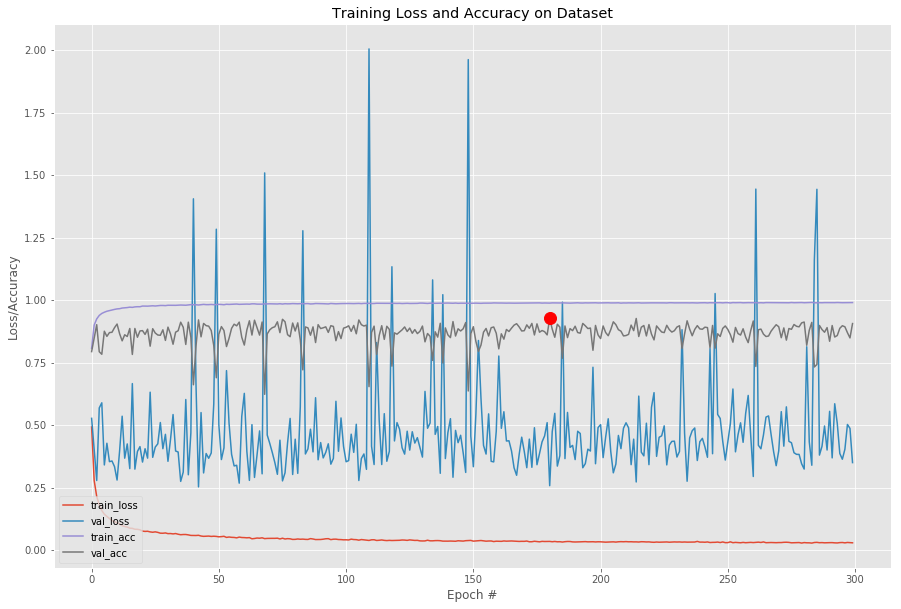

In [36]:
N = NUMBER_OF_EPOCHS
H = trainHistory
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label = "val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig(TRAIN_EVAL_PLOT_PATH + "/"+ MODEL_NAME +"_Loss_Accuracy.png")

ymax = max(H.history["val_acc"])
xpos = H.history["val_acc"].index(ymax)
print("Best val. Accuracy " + str(H.history["val_acc"][xpos]) + " at Epoch " + str(xpos+1))
plt.plot([xpos],[H.history["val_acc"][xpos]],"ro",markersize=12)
plt.show()

### Sources
- https://www.tensorflow.org/guide/keras
- http://rpg.ifi.uzh.ch/docs/RAL16_Giusti.pdf
- https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
- https://keras.io/models/sequential/